# CDados 2021.2 | Projeto 2: Previsão das Notas Finais de Estudantes
#### Por Matheus Castellucci, Mia Valentin Machado, Pedro Henrique Oliveira e Victor Assis.

### Pergunta:
Basereamos nosso trabalho na seguinte pergunta:

Dependendo das caracteristicas academicas do aluno ao longo de sua vida, suas condições socioêconomicas e seus resultados ao longo do ano escolar, qual será a nota final desse aluno?

### Objetivo:

Prever uma informação numérica (neste caso, o target é quantitativo), ao considerar outros 8 tipos de dados quantitativos.

### Técnicas utilizadas:

Regressão linear
Árvore de Decisão  
Random Forest

### Índices:

1. **Age** - idade do estudante (15 a 22 anos)  

2. **Traveltime** - tempo gasto para chegar à instituição (1: menos de 15 minutos, 2: de 15 a 30 minutos, 3: de 30 minutos a 1 hora, 4: mais de 1 hora)

3. **Studytime** - tempo de estudo individual semanal (1: menos de 2 horas, 2: de 2 até 5 horas, 3: de 5 a 10 horas, 4:  mais de 10 horas)

4. **Failures** - número de reprovações (n se menor ou igual a 3, caso contrário igual a 4)

5. **Absences** - número de faltas (0 a 93)

Além dessas, temos as variáveis:

    *G1 - first period grade (numeric: from 0 to 20)
    *G2 - second period grade (numeric: from 0 to 20)
    *G3 - final grade (numeric: from 0 to 20, output target)

### Trabalhos Acadêmicos:

Alguns estudos já realizdos sobre esse tema:
    
    https://muse.jhu.edu/article/201906
    https://journals.sagepub.com/doi/abs/10.3102/0002831219833917

### Importação de bibliotecas a serem utilizadas e leitura das bases

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import csv
import matplotlib.pyplot as plt

In [2]:
student_mat_data = pd.read_csv('student-mat.csv')

student_por_data = pd.read_csv('student-por.csv')

base = pd.concat([student_por_data,student_mat_data],ignore_index=True)

base

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039,MS,M,20,U,LE3,A,2,2,services,services,...,5,5,4,4,5,4,11,9,9,9
1040,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,3,14,16,16
1041,MS,M,21,R,GT3,T,1,1,other,other,...,5,5,3,3,3,3,3,10,8,7
1042,MS,M,18,R,LE3,T,3,2,services,other,...,4,4,1,3,4,5,0,11,12,10


### Índice do Dataset

Checagem de valores nulos, para garantir que não haja alteração nos valores finais.

In [3]:
base.isnull().sum()

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64

Definindo features categóricas

In [4]:
falsas_numericas = ['Medu', 'Fedu','famrel','freetime', 'goout','Walc', 'Dalc','health']
for column in falsas_numericas:
    base[column] = base[column].astype('category')
    
num_base = base.select_dtypes(include=[np.number]).columns
cat_base = base.select_dtypes(exclude=[np.number]).columns

print(num_base)
print("\n {}".format(cat_base))

Index(['age', 'traveltime', 'studytime', 'failures', 'absences', 'G1', 'G2',
       'G3'],
      dtype='object')

 Index(['school', 'sex', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid',
       'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health'],
      dtype='object')


Como nossa target se trata de uma variável quantitativa e acreditamos que a nota seja muito mais influenciada por fatores diretos, decidimos utilizar outras variáveis quantitativas, por reunirem features que se relacionam com ela diretamente. Por exemplo: studytime (tempo de estudo) apresenta grande correlação com o desempenho do aluno em uma prova, enquanto Mjob (trabalho exercido pela figura paterna) influencia de forma muito subjetiva a nota.

Assim utilizaremos apenas as seguintes variáveis: 

In [5]:
base.describe()

,age,traveltime,studytime,failures,absences,G1,G2,G3
count,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000
mean,16.726054,1.522989,1.970307,0.264368,4.434866,11.213602,11.246169,11.341954
std,1.239975,0.731727,0.834353,0.656142,6.210017,2.983394,3.285071,3.864796
min,15.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,1.000000,1.000000,0.000000,0.000000,9.000000,9.000000,10.000000
50%,17.000000,1.000000,2.000000,0.000000,2.000000,11.000000,11.000000,11.000000
75%,18.000000,2.000000,2.000000,0.000000,6.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,3.000000,75.000000,19.000000,19.000000,20.000000


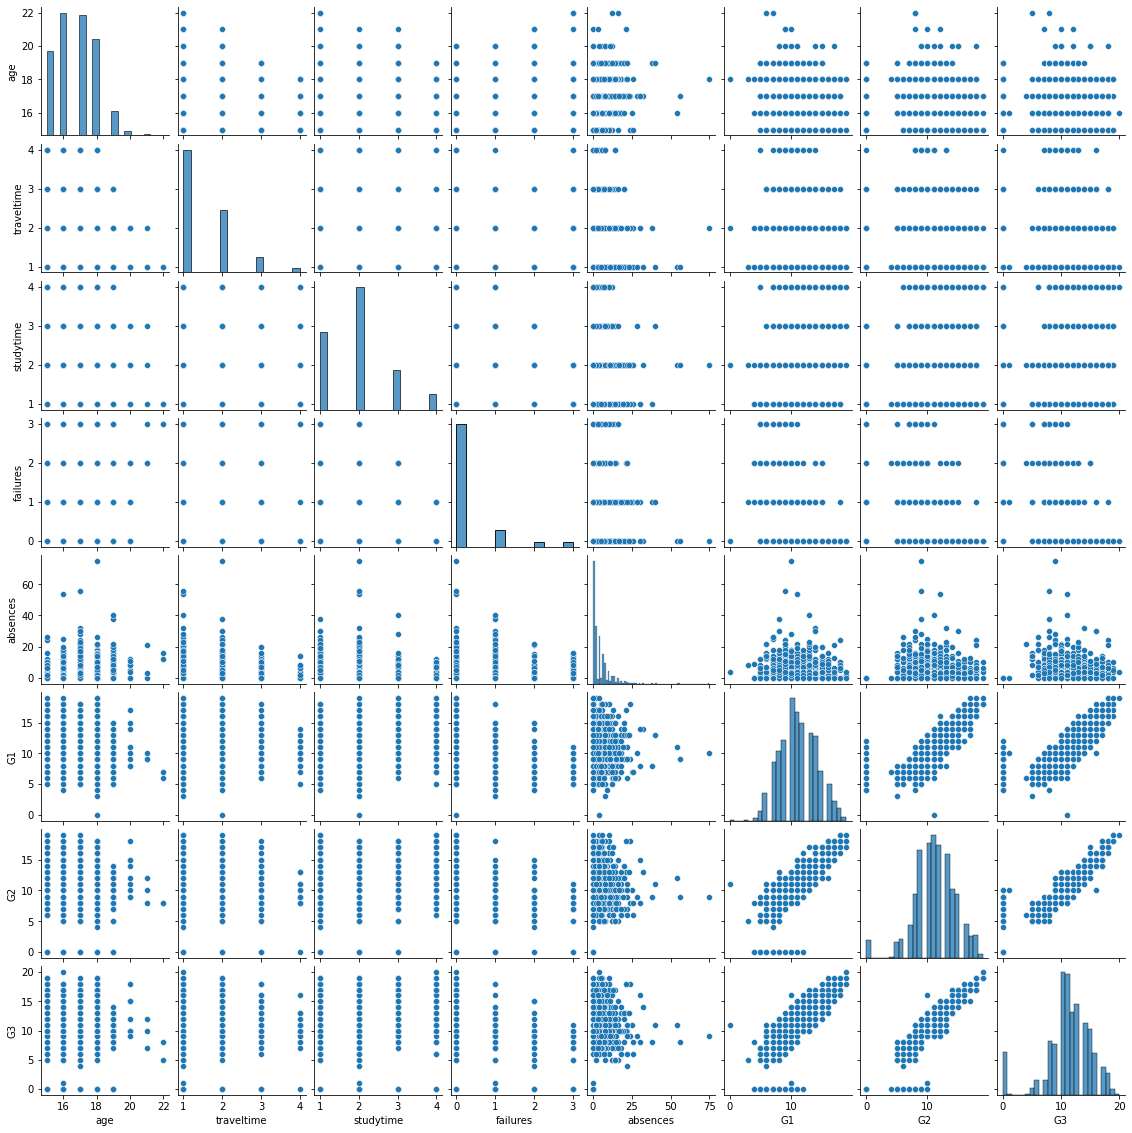

In [6]:
import seaborn as sns
sns.pairplot(base, height=2);

# Modelos de Predição

### Modelo 1 - Regressão Linear

Regressão linear é quando tentamos encontrar uma correlação entre 2 variáveis de tal modo que é possível estimar uma linha de tendência que um modelo ideal seguiria mas que um modelo real apenas se aproxima.



 

In [7]:
X = base[['age', 'failures', 'absences', 'G1', 'G2','traveltime','studytime']]
Y = base['G3']

In [8]:
import statsmodels.api as sm

def regress(Y,X):
    '''
    Y: coluna do DataFrame utilizada como variável resposta (TARGET)
    X: coluna(s) do DataFrame utilizadas como variável(is) explicativas (FEATURES)
    '''
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    
    return results

results = regress(Y,X)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     756.0
Date:                Wed, 01 Dec 2021   Prob (F-statistic):               0.00
Time:                        00:17:35   Log-Likelihood:                -1947.7
No. Observations:                1044   AIC:                             3911.
Df Residuals:                    1036   BIC:                             3951.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5194      0.726     -0.716      0.474      -1.944       0.905
age           -0.0349      0.041     -0.845      0.398      -0.116       0.046
failures      -0.2517      0.084     -3.012      0.003      -0.416      -0.088
absences       0.0264      0.008      3.312      0.001       0.011       0.042
G1             0.1278      0.032      3.977      0.000       0.065       0.191
G2             0.9626      0.029     33.041      0.000       0.905       1.020
traveltime     0.1500      0.067      2.229      0.026       0.018       0.282
studytime     -0.0470      0.060     -0.783      0.434      -0.165       0.071
==============================================================================
Omnibus:                      674.212   Durbin-Watson:                   1.795
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8627.436
Skew:                          -2.809   Prob(JB):                         0.00
Kurtosis:                      15.914   Cond. No.                         357.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
X = base[['age','failures', 'absences', 'G1', 'G2','traveltime']]
Y = base['G3']

In [10]:
results = regress(Y,X)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     882.2
Date:                Wed, 01 Dec 2021   Prob (F-statistic):               0.00
Time:                        00:17:35   Log-Likelihood:                -1948.0
No. Observations:                1044   AIC:                             3910.
Df Residuals:                    1037   BIC:                             3945.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5678      0.723     -0.785      0.432      -1.987       0.851
age           -0.0365      0.041     -0.886      0.376      -0.117       0.044
failures      -0.2461      0.083     -2.957      0.003      -0.409      -0.083
absences       0.0268      0.008      3.367      0.001       0.011       0.042
G1             0.1253      0.032      3.919      0.000       0.063       0.188
G2             0.9629      0.029     33.058      0.000       0.906       1.020
traveltime     0.1531      0.067      2.279      0.023       0.021       0.285
==============================================================================
Omnibus:                      676.992   Durbin-Watson:                   1.791
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8765.107
Skew:                          -2.821   Prob(JB):                         0.00
Kurtosis:                      16.026   Cond. No.                         354.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
X = base[['failures', 'absences', 'G1', 'G2','traveltime']]
Y = base['G3']

In [12]:
results = regress(Y,X)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     1059.
Date:                Wed, 01 Dec 2021   Prob (F-statistic):               0.00
Time:                        00:17:35   Log-Likelihood:                -1948.4
No. Observations:                1044   AIC:                             3909.
Df Residuals:                    1038   BIC:                             3938.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1683      0.251     -4.654      0.000      -1.661      -0.676
failures      -0.2644      0.081     -3.278      0.001      -0.423      -0.106
absences       0.0258      0.008      3.279      0.001       0.010       0.041
G1             0.1256      0.032      3.931      0.000       0.063       0.188
G2             0.9626      0.029     33.055      0.000       0.906       1.020
traveltime     0.1514      0.067      2.254      0.024       0.020       0.283
==============================================================================
Omnibus:                      682.516   Durbin-Watson:                   1.790
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8983.573
Skew:                          -2.846   Prob(JB):                         0.00
Kurtosis:                      16.195   Cond. No.                         90.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Implementação de gráfico: distribuição dos resultados de acordo com o erro esperado

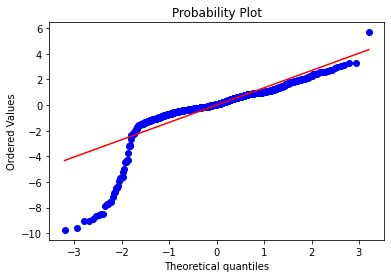

In [13]:
import matplotlib.pyplot as plt
from scipy.stats import norm, probplot

probplot(results.resid, dist="norm", plot= plt);

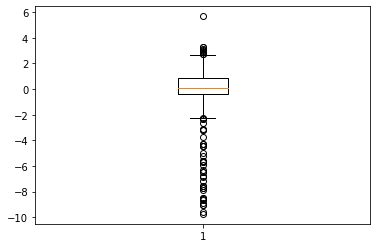

In [14]:
plt.boxplot(results.resid);

In [15]:
print(np.where(results.resid<-6))
print(np.where(results.resid>3))

(array([163, 172, 519, 586, 637, 639, 640, 789, 817, 888, 908, 913, 945,
       959, 965, 982, 983, 986, 990, 992], dtype=int64),)
(array([ 61, 307, 389, 518, 692], dtype=int64),)


In [16]:
base = base.drop(axis=0, index=[ 163, 172, 519, 586, 637, 639, 640, 789, 817, 888, 908, 913, 945,
       959, 965, 982, 983, 986, 990, 992, 61, 307, 389, 518, 692])

In [17]:
base

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039,MS,M,20,U,LE3,A,2,2,services,services,...,5,5,4,4,5,4,11,9,9,9
1040,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,3,14,16,16
1041,MS,M,21,R,GT3,T,1,1,other,other,...,5,5,3,3,3,3,3,10,8,7
1042,MS,M,18,R,LE3,T,3,2,services,other,...,4,4,1,3,4,5,0,11,12,10


In [18]:
X = base[['failures', 'absences', 'G1', 'G2','traveltime']]
Y = base['G3']

In [19]:
results = regress(Y,X)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     2103.
Date:                Wed, 01 Dec 2021   Prob (F-statistic):               0.00
Time:                        00:17:36   Log-Likelihood:                -1501.6
No. Observations:                1019   AIC:                             3015.
Df Residuals:                    1013   BIC:                             3045.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2112      0.174     -1.217      0.224      -0.552       0.129
failures      -0.2573      0.055     -4.672      0.000      -0.365      -0.149
absences       0.0060      0.005      1.122      0.262      -0.005       0.017
G1             0.0801      0.022      3.677      0.000       0.037       0.123
G2             0.9551      0.020     48.279      0.000       0.916       0.994
traveltime     0.0653      0.046      1.422      0.155      -0.025       0.155
==============================================================================
Omnibus:                      416.185   Durbin-Watson:                   1.742
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3470.801
Skew:                          -1.652   Prob(JB):                         0.00
Kurtosis:                      11.416   Cond. No.                         91.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
X = base[['failures', 'G1', 'G2','traveltime']]
Y = base['G3']

In [21]:
results = regress(Y,X)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     2628.
Date:                Wed, 01 Dec 2021   Prob (F-statistic):               0.00
Time:                        00:17:36   Log-Likelihood:                -1502.3
No. Observations:                1019   AIC:                             3015.
Df Residuals:                    1014   BIC:                             3039.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1691      0.169     -0.998      0.319      -0.502       0.163
failures      -0.2531      0.055     -4.606      0.000      -0.361      -0.145
G1             0.0793      0.022      3.644      0.000       0.037       0.122
G2             0.9547      0.020     48.261      0.000       0.916       0.994
traveltime     0.0631      0.046      1.375      0.169      -0.027       0.153
==============================================================================
Omnibus:                      425.084   Durbin-Watson:                   1.741
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3654.482
Skew:                          -1.686   Prob(JB):                         0.00
Kurtosis:                      11.643   Cond. No.                         86.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
X = base[['failures', 'G1', 'G2']]
Y = base['G3']
results = regress(Y,X)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     3501.
Date:                Wed, 01 Dec 2021   Prob (F-statistic):               0.00
Time:                        00:17:36   Log-Likelihood:                -1503.2
No. Observations:                1019   AIC:                             3014.
Df Residuals:                    1015   BIC:                             3034.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0535      0.147     -0.364      0.716      -0.342       0.235
failures      -0.2499      0.055     -4.549      0.000      -0.358      -0.142
G1             0.0795      0.022      3.648      0.000       0.037       0.122
G2             0.9528      0.020     48.262      0.000       0.914       0.992
==============================================================================
Omnibus:                      423.669   Durbin-Watson:                   1.740
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3640.902
Skew:                          -1.679   Prob(JB):                         0.00
Kurtosis:                      11.630   Cond. No.                         74.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

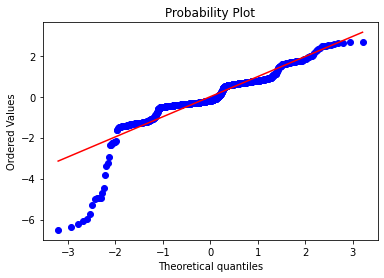

In [23]:
probplot(results.resid, dist="norm", plot= plt);

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, random_state= 100)
X_train_mod1 = X_train

In [25]:
results = regress(y_train,X_train)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     3173.
Date:                Wed, 01 Dec 2021   Prob (F-statistic):               0.00
Time:                        00:17:38   Log-Likelihood:                -1370.2
No. Observations:                 917   AIC:                             2748.
Df Residuals:                     913   BIC:                             2768.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0761      0.157     -0.483      0.629      -0.385       0.233
failures      -0.2621      0.058     -4.533      0.000      -0.376      -0.149
G1             0.0740      0.023      3.173      0.002       0.028       0.120
G2             0.9591      0.021     46.091      0.000       0.918       1.000
==============================================================================
Omnibus:                      383.260   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3204.290
Skew:                          -1.688   Prob(JB):                         0.00
Kurtosis:                      11.513   Cond. No.                         74.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
from sklearn.linear_model import LinearRegression
regressor_L = LinearRegression()
regressor_L.fit(X_train, y_train)

LinearRegression()

In [27]:
y_pred = regressor_L.predict(X_test)
y_pred

array([ 7.47683077, 12.24786081, 12.24786081, 10.18152737,  8.26323344,
       11.28871384, 14.53625351,  9.9594681 , 10.25554712, 11.28871384,
       12.24786081, 10.18152737, 14.46223376, 10.95255986, 14.46223376,
       13.35504728,  9.29640016, 17.4136944 , 11.28871384,  9.07434089,
        8.88622643, 13.28102753,  9.14836065, 11.3627336 ,  8.3372532 ,
       14.46223376, 13.35504728, 13.35504728, 14.46223376,  7.15604697,
       12.28180561, 14.31419424,  6.89391274, 17.63575367, 13.35504728,
       11.57555285,  9.37041992, 12.32188056, 17.26565489,  5.16373329,
       12.24786081,  9.37041992, 12.32188056, 12.32188056, 15.34736096,
       12.39590032, 12.54393983, 10.32956688,  7.23006672,  9.14836065,
        8.88622643, 13.35504728, 13.5030868 , 13.28102753, 16.45454744,
       11.3627336 ,  7.51690573, 10.18152737, 14.388214  , 14.46223376,
       11.28871384, 11.28871384, 10.25554712, 10.18152737, 12.09982129,
       11.21469409,  6.04886049, 11.21469409,  7.92707946,  6.19

In [28]:
df_Linear = pd.DataFrame({'Real Values':y_test, 'Predicted Values':y_pred})
df_Linear.head()

,Real Values,Predicted Values
806,10,7.476831
48,13,12.247861
363,14,12.247861
539,10,10.181527
150,9,8.263233


### Validando o 1º modelo

Obtemos o R², que indica o quão próximo os dados estão da regressão ajustada, ou seja, quanto maior o R, mais próximo o modelo está do ideal (taxa de acerto = 100%).

In [ ]:
from sklearn.metrics import r2_score
Rsqrt_Linear = r2_score(y_test, y_pred)
Rsqrt_Linear

'Mean Square Error(MSE)' - Erro Quadrático Médio, consiste da média dos erros ao quadrado -  
e 'Root Mean Squared Error (RMSE)' - raíz quadrada do MSE, que pode ser interpretada como um Desvio Padrão. 

In [ ]:
from sklearn.metrics import mean_squared_error
mseL= mean_squared_error(y_test, y_pred)
rmseL= mean_squared_error(y_test, y_pred, squared= False)
print(mseL)
print(rmseL)

Por fim, obtemos o 'Medium Absolute Error (MAE)' - Erro Absoluto Médio. Diferente dos indicadores MSE e RMSE, ele não é alterado pela presença de outliers no dataset.

In [ ]:
from sklearn.metrics import mean_absolute_error
maeL= mean_absolute_error(y_test, y_pred)
maeL

### Modelo 2: Árvore de Decisão (Decision Tree)

 Optamos utilizar a "Regression Tree", construída através de um processo chamado particionamento recursivo binário, que consiste em dividir os dados em partições ou ramificações e, em seguida, continuar dividindo cada partição em grupos menores conforme o método sobe em cada ramificação.

Inicialmente, todos os registros no Conjunto de treinamento são agrupados na mesma partição. O algoritmo então começa a alocar os dados nas duas primeiras partições ou ramificações, usando todas as divisões binárias possíveis em cada campo. Então ele seleciona a divisão que minimiza a soma dos desvios quadrados da média nas duas partições separadas. Essa regra de divisão é então aplicada a cada um dos novos ramos. Esse processo continua até que cada nó alcance um tamanho de nó mínimo especificado pelo usuário e se torne um nó terminal. (Se a soma dos desvios quadrados da média em um nó for zero, esse nó será considerado um nó terminal, mesmo que não tenha atingido o tamanho mínimo.)

In [ ]:
X = base[[ 'G1', 'G2','failures']]
Y = base['G3']

Separando a base de dados em 2 bases diferentes, uma de teste e outra de treinamento

In [ ]:
#Separando a base de dados em 2 bases diferentes, uma de teste e outra de treinamento
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, random_state= 100)

In [ ]:
X_train

In [ ]:
y_train

Importando todas as bibliotecas extras que iremos precisar.

In [ ]:
from numpy import reshape
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
from sklearn.tree import DecisionTreeRegressor
regressor_T = DecisionTreeRegressor()
regressor_T.fit(X_train, y_train)

In [ ]:
y_pred = regressor_T.predict(X_test)
y_pred

In [ ]:
Tree = pd.DataFrame({'Real Values':y_test, 'Predicted Values':y_pred})
Tree.head()

Aqui plotamos gráficos que mostram a descrepância entre os números do dataset e os previstos. Apenas para ter um entendimento visual do estado da regressão.



In [ ]:
plt.scatter(X_test['G1'], y_test, color = 'red')
plt.scatter(X_test['G1'], y_pred, color = 'green')
plt.title('Decision Tree Regression')
plt.xlabel('Nota G1')
plt.ylabel('Nota Final')
plt.show()

plt.scatter(X_test['G2'], y_test, color = 'red')
plt.scatter(X_test['G2'], y_pred, color = 'green')
plt.title('Decision Tree Regression')
plt.xlabel('Nota G2')
plt.ylabel('Nota Final')
plt.show()

plt.scatter(X_test['failures'], y_test, color = 'red')
plt.scatter(X_test['failures'], y_pred, color = 'green')
plt.title('Decision Tree Regression')
plt.xlabel('failures')
plt.ylabel('Nota Final')
plt.show()

Gráfico entre os valores do dataset e da previsão.



In [ ]:
plt.scatter(Tree['Real Values'],Tree['Predicted Values'] , color = 'red')
plt.title('Decision Tree Regression')
plt.xlabel('Valores reais')
plt.ylabel('Previsão')
plt.show()

Demonstração por texto do funcionamento da primeira árvore.



In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
regr = DecisionTreeRegressor(random_state=100)
regr.fit(X_train, y_train)
text_representation = tree.export_text(regr)
print(text_representation)

Aqui plotamos a árvore perfeita do nosso dataset, já que ela prevê quse perfeitamente nosso resultado. Porém, ela não se mostra tão útil para nossa análise, pois se mostra muito expecífica para este dataset.



In [ ]:
plt.figure(figsize=(50,40))
colunas = ['G1', 'G2', 'Reprovações']
fig = tree.plot_tree(regr, feature_names=colunas, filled=True)
plt.savefig('Arvore.png')

Calculo do R quadrado. Que represena o índice de correlação entre duas variaveis, ou seja, ela mede o quanto uma variavel influencia em uma outra variavel.



In [ ]:
from sklearn.metrics import r2_score
Rsqrt_Tree = r2_score(Tree['Predicted Values'], Tree['Real Values'])
Rsqrt_Tree

Demonstração por texto do funcionamento da segunda árvore.



In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
regr = DecisionTreeRegressor(max_depth=5, random_state=100)
regr.fit(X_train, y_train)
text_representation = tree.export_text(regr)
print(text_representation)

Aqui plotamos uma árvore com uma profundidade menor que a anterior, o que faz com que esta possa ser usada por uma gama maior de dataset, assim não se restringindo apenas ao dataset na qual foi treinada. Porém, ao optar por isso, estamos sacrificando a precisão da árvore. Ou seja, trocamos precisão por abrangencia.

In [ ]:
plt.figure(figsize=(50,40))
colunas = ['G1', 'G2', 'Reprovações']
fig = tree.plot_tree(regr, feature_names=colunas, filled=True)
plt.savefig('Arvore.png')

In [ ]:
y_pred_Tree = regr.predict(X_test)

In [ ]:
df_Tree = pd.DataFrame({'Real Values':y_test, 'Predicted Values':y_pred})
df_Tree.head()

## Validação do 2º modelo

R, MSE, RMSE e MAE:

In [ ]:
from sklearn.metrics import r2_score
Rsqrt_Tree = r2_score(Tree['Predicted Values'], Tree['Real Values'])
Rsqrt_Tree

In [ ]:
from sklearn.metrics import mean_squared_error
mseT= mean_squared_error(y_test, y_pred_Tree)
rmseT= mean_squared_error(y_test, y_pred_Tree, squared= False)
print(mseT)
print(rmseT)

In [ ]:
from sklearn.metrics import mean_absolute_error
maeT= mean_absolute_error(y_test, y_pred_Tree)
maeT

## Modelo 3 - Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
regressor_F = RandomForestRegressor(n_estimators = 50, random_state = 100)
regressor_F.fit(X_train, y_train);

In [ ]:
y_previsao_F = regressor_F.predict(X_test)
y_previsao_F

In [ ]:
Florest = pd.DataFrame({'Real Values':y_test, 'Predicted Values':y_previsao_F})
Florest.head()

## Validação do 3º modelo
R, MSE, RMSE e MAE:

In [ ]:
from sklearn.metrics import r2_score
Rsqrt_TreeF = r2_score(Florest['Real Values'], Florest['Predicted Values'])
Rsqrt_TreeF

In [ ]:
from sklearn.metrics import mean_squared_error
mseF= mean_squared_error(Florest['Real Values'], Florest['Predicted Values'])
rmseF= mean_squared_error(Florest['Real Values'], Florest['Predicted Values'], squared= False)
print(mseF)
print(rmseF)

In [ ]:
from sklearn.metrics import mean_absolute_error
maeF= mean_absolute_error(Florest['Real Values'], Florest['Predicted Values'])
maeF

## Conclusão

In [ ]:
comparador = pd.DataFrame.from_dict({
        "Regressão Linear": [Rsqrt_Linear,maeL,mseL,rmseL],
        "Decision Tree":[Rsqrt_Tree,maeT,mseT,rmseT],
        "Regressão Random Forest":[Rsqrt_TreeF,maeF,mseF,rmseF]} )
df

Comparando os índices de confiabilidade dos 3 modelos juntos, percebemos a proximidade entre seus valores. Isso se deve ao enviesamento de nossa base de dados - como mostrado na 2ª árvore do modelo 2, no qual as principais orientações eram dadas em favor de G2, não seria necessário escolhermos um modelo específico, já que nosso dataset é tão simples a ponto de não precisar de nenhum modelo robusto para prever nossa target com exatidão.  

Uma das explicações possíveis é: como as provas G1, G2 e G3 ocorreram em sequência, é muito provável que um estudante que tenha tido bom desempenho na 2ª prova também terá um bom desempenho na 3ª prova.


## Bibliografia:

https://ensinandomaquinasblog.wordpress.com/2017/12/15/modelos-preditivos-de-notas-de-redacao-do-enem-2015/  
https://www.fm2s.com.br/regressao-linear-economizar-milhoes/  
https://estatsite.com.br/2016/02/16/analise-dos-residuos-de-uma-regressao-linear/  
https://towardsdatascience.com/what-are-the-best-metrics-to-evaluate-your-regression-model-418ca481755b  
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html  
https://towardsdatascience.com/machine-learning-basics-decision-tree-regression-1d73ea003fda  

